# Simulating the Stock Market with Agent Based Modelling from Frequencies of Trading

In [167]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
import statistics

from utils import decorate, savefig

ModuleNotFoundError: No module named 'utils'

The following two classes represent the two agents. `LFTAgent` represents a trader with a lower frequency of trading, and `HFTAgent`
represents a higher frequency agent. There likeliness to trade is based off of the random library, where the Higher Frequency traders 
will have a higher chance of trading.

In [38]:
class Agent:
    
    def __init__(self, agent_type, num):
        
        self.agent_type = agent_type
        self.shares = 0
        self.agentNum = num
        
        if self.agent_type == 'HFT':
            self.trade_prob = 3
        if self.agent_type == 'RET':
            self.trade_prob = 10
        if self.agent_type == 'INT':
            self.trade_prob = 20
        
    def trade(self, priceTrade):
        
        x = random.randrange(1, self.trade_prob)
        if x == 1:
            if priceTrade == 0:
                # more likely to buy
                y = random.randrange(0,4)
                return y
            else:
                # more likely to sell
                y = random.randrange(1,5)
                return y
            
        else:
            return 0

Next, the `modelStock` class is defined. This class takes in six parameters. `start` is the starting price of the stock. `numINT`, `numRET` and `numHFT` represent the amount of low and high frequency traders for the simulation. `time` represents the amount of time the traders have an opportunity to trade. `shares` represents the total number of shares the stock has. This class right now is a very simple model of a stock that will be changed to represent different situations. When the `simulate` method is ran, traders will have opportunities to buy and sell based on their frequencies. A variable in "simulate" called `priceChange` is fed to the agents after each iteration. This variable represents whether the price of the stock has recently gone up or down. Based on this variable, an agent is more likely to buy or sell. After the trading has occured, the price of the stock is calculated. For this first simple implementation, if the there was more buying than selling, the stock is raised by 1%. If there was more selling, the stock is lowered by 1%.

In [39]:
class modelStock:
    
    def __init__(self, start=10, numINT=10, numRET=100, numHFT=1000, time=1000, shares=1e7):
        
        self.numINT = numINT          # number of institutional traders
        self.numRET = numRET          # number of retail traders
        self.numHFT = numHFT          # number of high frequency traders
        self.price = start            # starting price of the stock
        self.time = time              # period of time in which traders can trade
        self.shares = shares          # number of shares outstanding
        self.y = [self.price]
        
    def makeAgents(self):
        agents = []
        for i in range(self.numINT):
            agent = Agent('INT', i+1)
            agents.append(agent)
        
        for i in range(self.numRET):
            agent = Agent('RET', i+1)
            agents.append(agent)
            
        for i in range(self.numHFT):
            agent = Agent('HFT', i+1)
            agents.append(agent)
            
        self.agents = agents
        
    def printAgents(self):
        for i in self.agents:
            print(i.agent_type + str(i.agentNum))
            
    def simulate(self):
        buy = 1
        sell = 1
        priceChange = 0       # variable that shows whether price has gone up or down for agents
        
        for i in range(self.time - 1):
            buy = 1
            sell = 1
           # self.price = random.randrange(1,10)
            for j in self.agents:
                trade = j.trade(priceChange)
                if trade != 0:
                  #  print(trade)
                    if trade < 3:
                        if self.shares != 0:
                            buy = buy + 1
                            j.shares = j.shares + 1
                            self.shares = self.shares - 1
                    elif trade >= 3 and j.shares != 0:
                        sell = sell + 1
                        j.shares = j.shares - 1
                        self.shares = self.shares - 1
                    
                if buy > sell:
                    self.price = self.price * 1.01
                    priceChange = 0
                  #  print(self.price)
                elif sell > buy:
                    priceChange = 1
                    self.price = self.price * 0.99
                
            # iterate through traders and produce trades
            self.y.append(self.price)
            
        return
    
    
    def plot(self):
       # print(self.y)
        x = []
        for i in range(self.time):
            x.append(i)
            
        plt.plot(x,self.y)

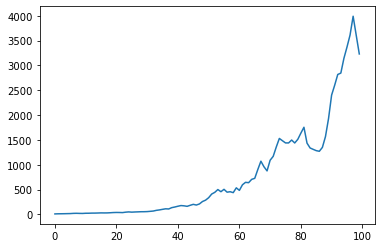

In [40]:
STONK = modelStock(10, 10, 2, 10, 100, 100000)
STONK.makeAgents()
# STONK.printAgents()
STONK.simulate()
STONK.plot()

Next, we add more functionality to the `Agent` class. We reused redundant code between different agent types. We also started storing the amount of shares owned, the block size quantity that the agent trades with, and a more updated trade algorithm.
Within `trade`, the agent will determine if the price over the past has been trending upwards, which will result in a higher probability of selling to secure profits. It utilizes the same probability mechanism that was used in the simpler model, but with added conditions. We made it so that the agent cannot own more than 4 times its initial alloted shares, otherwise it must sell a block. Also, the quantity being returned from the `trade` function is the actual number of shares which more accurately represents buying and selling pressures in the market.

In [151]:
class Agent:
    
    def __init__(self, agent_type, shares, num):
        
        self.agent_type = agent_type
        self.shares = shares
        self.block_size = shares/10
        self.agentNum = num
        
        if self.agent_type == 'HFT':
            self.trade_prob = 3
        if self.agent_type == 'RET':
            self.trade_prob = 10
        if self.agent_type == 'INT':
            self.trade_prob = 20
        
    def trade(self, priceTrade, price_history, i):
        
        x = random.randrange(1, self.trade_prob) #Actor will make a trade with a predefined probability
        if x == 1:
            if priceTrade == 0: # more likely to buy, price increasing
                y = random.randrange(0,4)
            else: # more likely to sell
                y = random.randrange(1,5)
                
            # y < 3 [BUY], y >= 3 [SELL]
            if (i > 30) and (i % 5 == 0):
                if price_history[i] > price_history[i-25]: # Price trending upwards for the past 25 timesteps
                    y-= 1 # Increase likelihood to take profits (sell)
                    
            if y<3 and self.shares< 40*self.block_size: # buy, with the condition that you cannot own more than 4*initial shares
                order = self.block_size
            elif y<3 and self.shares> 40*self.block_size:
                order = -1 * (self.block_size)
            
            if y>=3 and self.shares > 0: # sell, with the condition that you must own at least one blocksize
                order = -1 * (self.block_size)
            elif y>=3 and self.shares < 0:
                order = self.block_size
                
            return order # return order to be placed on the market
            
        else:
            return 0

This version of `modelStock` allows more parameter customisation. The market tracks the total number of shares being bought and sold in order to get a real sense of buying and selling pressures. This is more accurate than the last model as an institutional trader will have a bigger impact on price than a retail investor for example. 
The market mechanism updates the stock price proportional to the buy/sell ratio to more accurately emulate a market. Also, it clears all filled orders from the market after each time step. Unfilled order quantities are carried over to the next time stamp.
The `plot` and `plotvol` function make plots of both the stock price being tracked, and the quantity of shares being traded at a time, similarly to a real stock market chart.

In [154]:
class modelStock:
    
    def __init__(self, start=10.00, numINT=10, numRET=100, numHFT=1000, time=1000, shares=1e7):
        
        self.numINT = numINT          # number of institutional traders
        self.numRET = numRET          # number of retail traders
        self.numHFT = numHFT          # number of high frequency traders
        self.price = start            # starting price of the stock in $
        self.time = time              # period of time in which traders can trade
        self.shares = shares          # number of shares outstanding
        self.y = [self.price]
        self.vol = [0]
        
    def makeAgents(self, shareINT, shareRET, shareHFT):
        
        share_countINT = int((shareINT*self.shares)/self.numINT)
        share_countRET = int((shareRET*self.shares)/self.numRET)
        share_countHFT = int((shareHFT*self.shares)/self.numHFT)
        
        agents = []
        for i in range(self.numINT):
            agent = Agent('INT', share_countINT, i+1)
            agents.append(agent)
        
        for i in range(self.numRET):
            agent = Agent('RET', share_countRET, i+1)
            agents.append(agent)
            
        for i in range(self.numHFT):
            agent = Agent('HFT', share_countHFT, i+1)
            agents.append(agent)
            
        self.agents = agents

    def printAgents(self):
        for i in self.agents:
            print(i.agent_type + str(i.agentNum))

    def simulate(self):
        buys = 1        #'Pool' of buy orders and sell orders, expressed in quantity of shares
        sells = 1
        priceChange = 0 # variable that shows whether price has gone up or down for agents (0-increase, 1-decrease)

        for i in range(self.time - 1): # iterate through traders and produce trades

            for j in self.agents:

                trade = j.trade(priceChange, self.y, i)

                if trade>0: #If an agent put in a buy-order increase buy-pool, etc.
                    buys+=trade
                else:
                    sells-=trade

            if buys > sells:
                self.price += 0.01 * buys/sells
                priceChange = 0
            elif sells > buys:
                self.price -= 0.01 * sells/buys
                priceChange = 1

            self.y.append(self.price)
            self.vol.append(min(buys,sells))
            
            # print(str(buys) + '   ' + str(sells))
            temp = buys
            buys -= (min(buys, sells) - 1)
            sells -= (min(temp, sells) - 1)
            # print(str(buys) + '   ' + str(sells))
            # print()
        return


    def plot(self):
       # print(self.y)
        x = []
        for i in range(self.time):
            x.append(i)

        plt.plot(x,self.y)
        
    def plotvol(self):
       # print(self.y)
        x = []
        for i in range(self.time):
            x.append(i)

        plt.plot(x,self.vol)

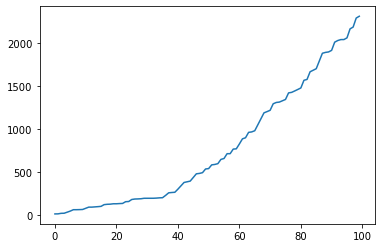

In [155]:
# (self, start=10.00, numINT=10, numRET=100, numHFT=1000, time=1000, shares=1e7):
STONK = modelStock(10, 2, 50, 1, 100, 10000)
STONK.makeAgents(0.5, 0.2, 0.3)
# STONK.printAgents()
STONK.simulate()
STONK.plot()

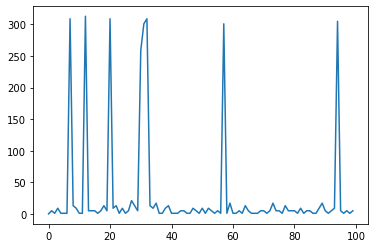

In [156]:
STONK.plotvol()

In [157]:
statistics.stdev(STONK.y)

705.6794652541529

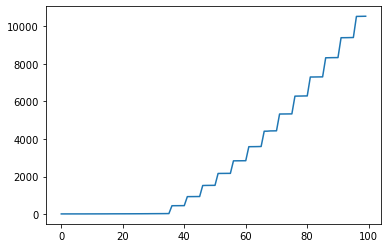

In [158]:
# (self, start=10.00, numINT=10, numRET=100, numHFT=1000, time=1000, shares=1e7):
STONK = modelStock(10, 2, 1, 50, 100, 100000)
STONK.makeAgents(0.5, 0.2, 0.3)
# STONK.printAgents()
STONK.simulate()
STONK.plot()

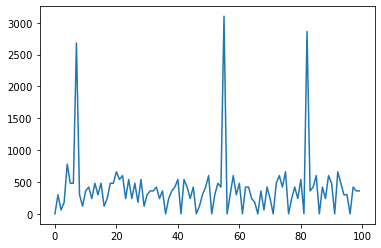

In [159]:
STONK.plotvol()

In [160]:
statistics.stdev(STONK.y)

3401.724517188177

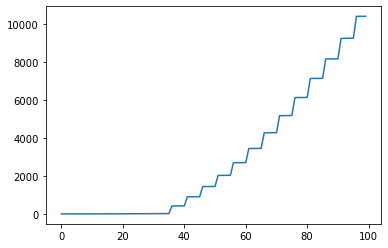

In [164]:
# (self, start=10.00, numINT=10, numRET=100, numHFT=1000, time=1000, shares=1e7):
STONK = modelStock(10, 2, 50, 1000, 100, 100000)
STONK.makeAgents(0.5, 0.2, 0.3)
# STONK.printAgents()
STONK.simulate()
STONK.plot()

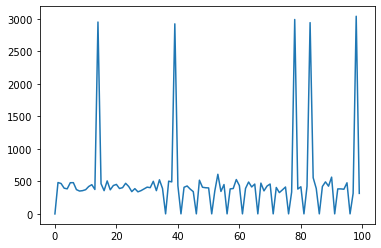

In [165]:
STONK.plotvol()

In [166]:
statistics.stdev(STONK.y)

3349.40629184992

As evidenced by these few simulations, as the number and proportion of HFT increases in a market place, the volatility of a stock (measured by its standard deviation) increases. With 1000, 50, and 1 HFT, the standard deviation went from approximately 3400 to 705. Although the model did not provide completely accurate and desirable stock price action (overwhelming buying and constant upward pressure on price), it does begin to give us insight on our hypothesis of more HFT leading to more volatile stock prices.